In [45]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point
import plotly_express as px
import plotly.io as pio
import numpy as np
import folium
from folium.plugins import HeatMap
from folium import branca
from branca.element import Figure

#### Visualizations for votes in Rio Grande do Sul in 2022

In [2]:
df = pd.read_csv(r"CSV/votacao_secao_2022_BR.csv", encoding="Latin 1", sep=";")

In [3]:
df_nome_locais = df[['NM_MUNICIPIO', 'NR_ZONA', 'NR_SECAO','NR_LOCAL_VOTACAO','NM_LOCAL_VOTACAO', 'DS_LOCAL_VOTACAO_ENDERECO']].drop_duplicates()
df_nome_locais.to_csv('CSV/NomesLocais.csv')

In [4]:
geocoded_df = pd.read_csv("CSV/geocoded_voting_places_001.csv")

In [5]:
df_lat_long = df.merge(geocoded_df, on = ['CD_MUNICIPIO', 'NR_ZONA', 'NR_LOCAL_VOTACAO'], how = 'left')

In [6]:
df_turno2_pres_rs_poa = df_lat_long[
    (df_lat_long['NR_TURNO']==2)&
    (df_lat_long['NM_MUNICIPIO']=='PORTO ALEGRE')&
    (df_lat_long['SG_UF']=='RS')&
    (df_lat_long['DS_CARGO']=='PRESIDENTE')&
    ((df_lat_long['NM_VOTAVEL']=='LUIZ INÁCIO LULA DA SILVA')|(df_lat_long['NM_VOTAVEL']=='JAIR MESSIAS BOLSONARO'))
    ][['NR_ZONA','NM_VOTAVEL','QT_VOTOS','NR_LATITUDE','NR_LONGITUDE','NM_LOCAL_VOTACAO']].groupby(by=
    ['NR_LATITUDE','NR_LONGITUDE','NR_ZONA','NM_VOTAVEL','NM_LOCAL_VOTACAO']).sum('QT_VOTOS')


In [7]:
df_turno2_pres_rs_poa_pivot = pd.pivot_table(df_turno2_pres_rs_poa, values = 'QT_VOTOS', index=['NR_LATITUDE','NR_LONGITUDE','NR_ZONA','NM_LOCAL_VOTACAO'], columns = 'NM_VOTAVEL').reset_index()
df_turno2_pres_rs_poa_pivot['difference'] = df_turno2_pres_rs_poa_pivot['LUIZ INÁCIO LULA DA SILVA']-df_turno2_pres_rs_poa_pivot['JAIR MESSIAS BOLSONARO']
df_turno2_pres_rs_poa_pivot['size'] = df_turno2_pres_rs_poa_pivot['difference'].abs()
df_turno2_pres_rs_poa_pivot.dropna(inplace=True)

In [8]:
long = df_turno2_pres_rs_poa_pivot['NR_LONGITUDE']
lat =  df_turno2_pres_rs_poa_pivot['NR_LATITUDE']
geometry = [Point(xy) for xy in zip(long,lat)]
geo_df = gpd.GeoDataFrame(geometry = geometry)
geo_df['size'] = df_turno2_pres_rs_poa_pivot['size']
geo_df['diff'] = df_turno2_pres_rs_poa_pivot['difference']
geo_df['NR_ZONA'] = df_turno2_pres_rs_poa_pivot['NR_ZONA']
geo_df['size_s'] = geo_df['size']/5 

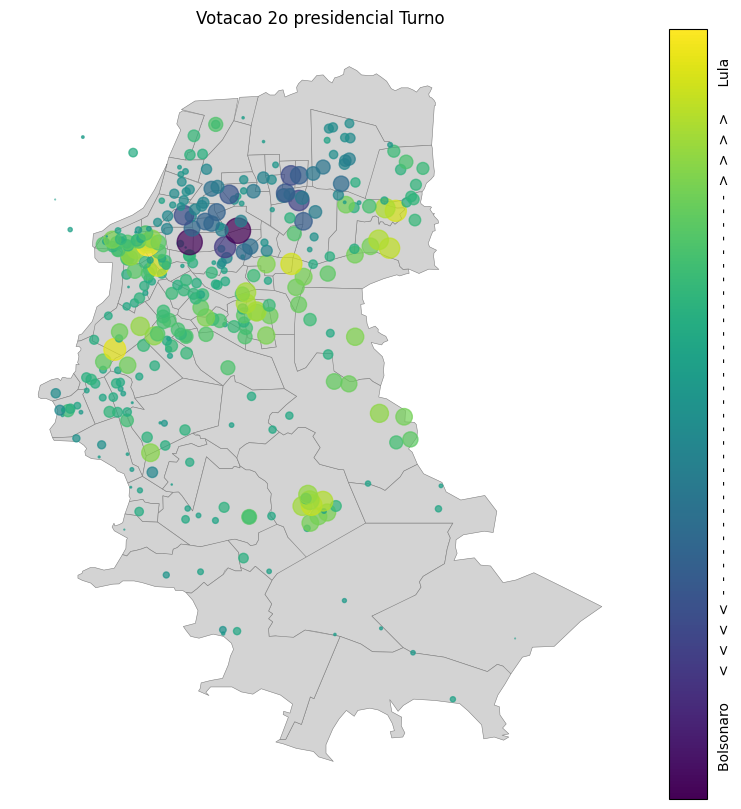

In [9]:
poa_map = gpd.read_file('Shapefiles/Zonas_Poa.shp')

fig, ax = plt.subplots()
axa = poa_map.plot(ax=ax, color='lightgray', edgecolor='grey', linewidth=0.4)
axb = geo_df.plot(ax=ax, c=geo_df['diff'], markersize='size_s', alpha=0.7, categorical=False, legend=True )
mappable = ax.collections[0]
fig.colorbar(mappable=mappable, ticks=[], label='Bolsonaro      <  <  <  <  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  >  >  >  >      Lula')
fig.set_figheight(10)
fig.set_figwidth(10)
plt.title('Votacao 2o presidencial Turno')
plt.axis('off')
plt.show()

In [10]:
df_turno2_pres_rs_poa_pivot['total_v'] = df_turno2_pres_rs_poa_pivot['JAIR MESSIAS BOLSONARO'] + df_turno2_pres_rs_poa_pivot['LUIZ INÁCIO LULA DA SILVA'] 

In [11]:
lat_foc = -30
lon_foc = -51
fig = px.scatter_mapbox(df_turno2_pres_rs_poa_pivot,lat="NR_LATITUDE",
    lon="NR_LONGITUDE",size='total_v',color='difference', custom_data=['NR_ZONA', 'NM_LOCAL_VOTACAO', 'difference', 'total_v']).update_layout(mapbox={"style": "carto-positron", "zoom": 4}, margin={"t":0,"b":0,"l":0,"r":0})
fig.update_traces(
    hovertemplate="<br>".join([
        "Zona: %{customdata[0]}",
        "Local: %{customdata[1]}",
        "Diferenca: %{customdata[2]}",
        "Total Votos: %{customdata[3]}"
    ])
)

#pio.write_html(fig, file='HTML files/Votos_RS_2oTurno.html', auto_open=True)
fig.show()

In [12]:
from scipy.interpolate import NearestNDInterpolator
import matplotlib.pyplot as plt
rng = np.random.default_rng()
x = rng.random(10) - 0.5
y = rng.random(10) - 0.5
z = np.hypot(x, y)


X = np.linspace(min(x), max(x))
Y = np.linspace(min(y), max(y))
X, Y = np.meshgrid(X, Y)  # 2D grid for interpolation

interp = NearestNDInterpolator(list(zip(x, y)), z)

interp

In [13]:
df_turno2_pres_rs_poa_pivot

NM_VOTAVEL,NR_LATITUDE,NR_LONGITUDE,NR_ZONA,NM_LOCAL_VOTACAO,JAIR MESSIAS BOLSONARO,LUIZ INÁCIO LULA DA SILVA,difference,size,total_v
0,-30.241619,-51.078808,161,EEEF GENOVEVA DA COSTA BERNARDES,587,656,69,69,1243
1,-30.220456,-51.096950,161,EEEM OSCAR COELHO DE SOUZA,1180,1130,-50,50,2310
2,-30.213958,-51.050490,161,EEEF HEITOR VILLA-LOBOS,79,80,1,1,159
3,-30.212151,-51.132472,161,EEEF MARGARIDA COELHO DE SOUZA,170,156,-14,14,326
4,-30.211709,-51.183310,161,EEEF EVARISTA FLORES DA CUNHA,1372,1346,-26,26,2718
...,...,...,...,...,...,...,...,...,...
335,-29.981437,-51.133382,158,SALAO PAROQUIAL DA IGREJA SANTA CATARINA,986,769,-217,217,1755
336,-29.980086,-51.186704,111,ESCOLA ESTADUAL DE 1 GRAU JOSE GARIBALDI,1420,1592,172,172,3012
337,-29.980075,-51.186703,111,ESCOLA MUNIC. DE 1º GRAU VEREADOR ANTÔNIO GIUDICE,1797,2302,505,505,4099
338,-29.979634,-51.125881,158,PRES. JOAO BELCHIOR M. GOULART - ESC. MUN. DE ...,1069,873,-196,196,1942


In [53]:
df_turno2_pres_rs_poa_pivot[df_turno2_pres_rs_poa_pivot.duplicated(subset=['NR_LONGITUDE'])]

NM_VOTAVEL,NR_LATITUDE,NR_LONGITUDE,NR_ZONA,NM_LOCAL_VOTACAO,JAIR MESSIAS BOLSONARO,LUIZ INÁCIO LULA DA SILVA,difference,size,total_v
19,-30.158653,-51.171487,161,EMEF NOSSA SENHORA DO CARMO,316,761,445,445,1077
108,-30.076552,-51.200196,113,NOSSA SENHORA DA GLORIA - COLEGIO,1680,2178,498,498,3858
203,-30.037006,-51.143950,112,ESCOLA ESTADUAL DE ENSINO FUNDAMENTAL TOYAMA,886,834,-52,52,1720
216,-30.034647,-51.217658,113,GREMIO NAUTICO UNIAO - SEDE PETROPOLE TENIS CLUBE,1395,1226,-169,169,2621
217,-30.034647,-51.217658,113,JOSE MARIANO BECK - ESCOLA MUNICIPAL,587,1384,797,797,1971
218,-30.034647,-51.217658,113,NOSSA SENHORA DE FATIMA - ESCOLA MUNICIPAL,745,2098,1353,1353,2843


In [54]:
df_turno2_pres_rs_poa_pivot.drop_duplicates(subset='NR_LATITUDE', keep="last", inplace=True)

In [62]:
df_map_lula = df_turno2_pres_rs_poa_pivot[df_turno2_pres_rs_poa_pivot['difference']>0][['NR_LATITUDE','NR_LONGITUDE','size']]
df_map_jair = df_turno2_pres_rs_poa_pivot[df_turno2_pres_rs_poa_pivot['difference']<0][['NR_LATITUDE','NR_LONGITUDE','size']]

In [101]:
df_map_lula.columns = ['lat','lon','val']
df_map_jair.columns = ['lat','lon','val']

# plotting the map, both the points themselves and the heatmap
# for elt in list(zip(df.lat, df.lon, df.value)):
#     folium.Circle(elt[:2], color="white", radius=elt[2]).add_to(m)
# df.values used here is a (250, 3) numpy.ndarray
# with (lat, lon, weight) for each data point



fig = Figure(width=800, height=600)
m = folium.Map(location = [-30.1, -51.2], tiles="OpenStreetMap",
               zoom_start=11, width=800, height=600)
lgd_txt = '<span style="color: {col};">{txt}</span>'

HeatMap(data=df_map_lula.values, min_opacity=0.1, gradient={.4: 'purple', .65: 'yellow', 1: 'orange'}, name=lgd_txt.format( txt= 'Votos Lula', col= 'orange')).add_to(m)
HeatMap(data=df_map_jair.values, min_opacity=0.1, gradient={.4: 'purple', .65: 'lime', 1: 'green'}, name=lgd_txt.format( txt= 'Votos Bolsonaro', col= 'green')).add_to(m)
fg = folium.FeatureGroup(name= lgd_txt.format( txt= 'Empate', col= 'purple'))
m.add_child( fg)
folium.map.LayerControl('topright', collapsed= False).add_to(m)


m.save('HTML files/Heatmap_Poa_2oTurno.html')
fig.add_child(m)
